# EDA of bank dataset

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [2]:
df_bank_client_data = pd.read_csv('data/bank_client_data.csv', sep=':', index_col='ID')
df_last_contacted_data = pd.read_csv('data/last_contact_data.csv', sep='=', index_col='ID')
df_other_data = pd.read_csv('data/other_data.csv', sep=' ', index_col='ID')
df_social_data = pd.read_csv('data/social_data.csv', sep=' ', index_col='ID')
df_outcome_data = pd.read_csv('data/outcome_data.csv', sep=' ', index_col='ID')

In [3]:
df = pd.concat(
    [df_bank_client_data, df_last_contacted_data, df_other_data, df_social_data, df_outcome_data], 
    axis=1,
    sort=True
)

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
000DYWU0VS,31,blue-collar,married,basic.6y,no,yes,no,telephone,jun,fri,...,12,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
000MW30CV5,46,entrepreneur,married,unknown,unknown,yes,no,telephone,may,fri,...,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
001OSJ7YP2,45,management,married,university.degree,no,no,yes,cellular,nov,wed,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
00331JKVWQ,37,services,married,high.school,no,no,no,cellular,may,tue,...,5,999,2,failure,-1.8,92.893,-46.2,1.291,5099.1,no
0037XS88TU,33,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no


## EDA

### Dataframe general

In [5]:
df.isnull().mean()

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64

In [6]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [7]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [8]:
binary = ['default', 'housing', 'loan']

for col in binary:
    print('{}\n'.format(df[col].value_counts()))

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64



Turn the binary columns into 1s and 0s.  Will put unknown as nan (may filter these out later).

In [9]:
def parse_binary(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return np.nan
    
for col in binary:
    df[col] = df[col].apply(parse_binary)

In [10]:
df[binary].isnull().mean()

default    0.208726
housing    0.024036
loan       0.024036
dtype: float64

Quite alot of unknowns in default and not many in others. Will leave this in for now but remove if need be.

Convert the response to boolean:

In [11]:
df.y = df.y.apply(lambda x: True if x == 'yes' else False)
successful = (df.y == True)
failed = (df.y == False)

***

Overall success rate:

Success rate = 0.11


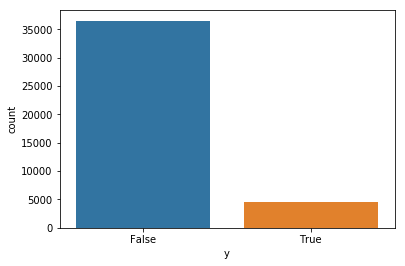

In [12]:
print('Success rate = {:.2f}'.format(df.y.mean()))
sns.countplot(df.y);

So most people dont go for the product.  Don't have the context of wheter this is a good or bad success rate when benchmarked agains other products / banks etc.

### Features

Having a look at each feature:

#### age

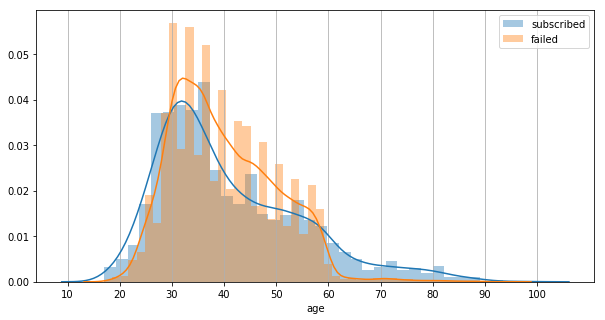

In [18]:
plt.figure(figsize=(10, 5))
sns.distplot(df[successful].age, label='subscribed')
sns.distplot(df[failed].age, label='failed')
plt.xticks(np.arange(10, 101, 10))
plt.grid(axis='x')
plt.legend();

* Big drop off around 60 (common retirement age) in failed.  Possible that product mught be more suitable to retirees.

#### job

In [19]:
success_by_job = df.groupby('job').y.mean().rename('success_rate').reset_index()

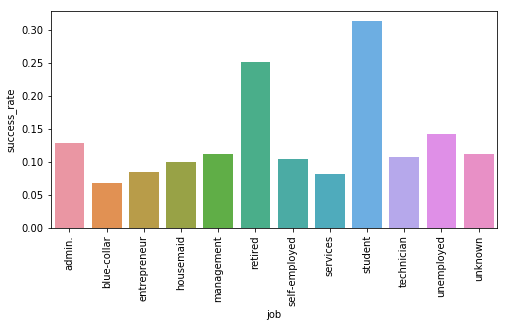

In [20]:
plt.figure(figsize=(8, 4))
sns.barplot(x=success_by_job.job, y=success_by_job.success_rate)
plt.xticks(rotation=90);

* Student and retired ahve hight success rates.  Both are not in full time work - product may suit them OR perhaps contact is happening in office hours.

#### marital

In [21]:
df.marital.value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [22]:
success_by_marital = df.groupby('marital').y.mean().rename('success_rate').reset_index()

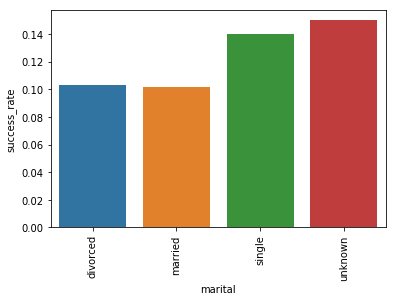

In [23]:
sns.barplot(x=success_by_marital.marital, y=success_by_marital.success_rate)
plt.xticks(rotation=90);

* Slightly higher for single but not much in it.

***

#### education

In [24]:
df.education.value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [25]:
success_by_education = df.groupby('education').y.mean().rename('success_rate').reset_index()

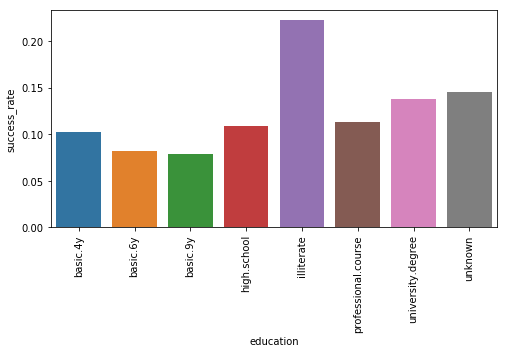

In [26]:
plt.figure(figsize=(8, 4))
sns.barplot(x=success_by_education.education, y=success_by_education.success_rate)
plt.xticks(rotation=90);

* Illiterate is high but there is a very small sample size.  Out of the rest there isn't an obvious pattern.

***

#### default, housing, loan

In [27]:
for col in binary:
    print(df[col].value_counts())

0.0    32588
1.0        3
Name: default, dtype: int64
1.0    21576
0.0    18622
Name: housing, dtype: int64
0.0    33950
1.0     6248
Name: loan, dtype: int64


In [28]:
success_by_default = df.groupby('default').y.mean().rename('success_rate').reset_index()
success_by_housing = df.groupby('housing').y.mean().rename('success_rate').reset_index()
success_by_loan = df.groupby('loan').y.mean().rename('success_rate').reset_index()

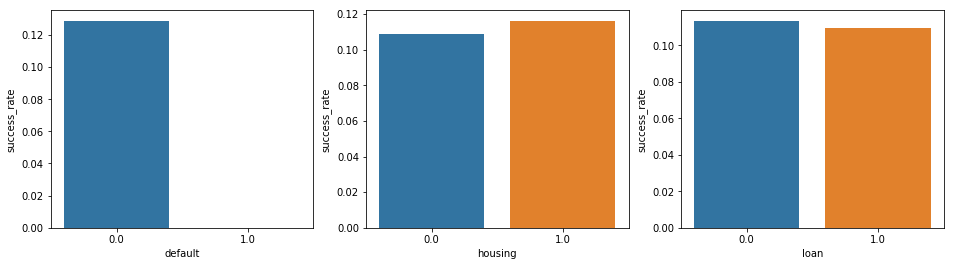

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.barplot(x=success_by_default.default, y=success_by_default.success_rate, ax=ax[0])
sns.barplot(x=success_by_housing.housing, y=success_by_housing.success_rate, ax=ax[1])
sns.barplot(x=success_by_loan.loan, y=success_by_loan.success_rate, ax=ax[2]);

* No success with default - this could be as they weren't offered it (although 3 have it). Should seeif they have been contacted (this will be in the 'campaign' feature.
* Success rate is similar for housing and loan catagories.

In [30]:
df[df.default == 0].campaign.count()

32588

* So there were 32588 wasted calls - either people who have been in default don't want the product, or they are not offered it but this is not found out until after contact.

***

#### contact

In [31]:
df.contact.value_counts()

cellular     26144
telephone    15044
Name: contact, dtype: int64

In [32]:
success_by_contact = df.groupby('contact').y.mean().rename('success_rate').reset_index()

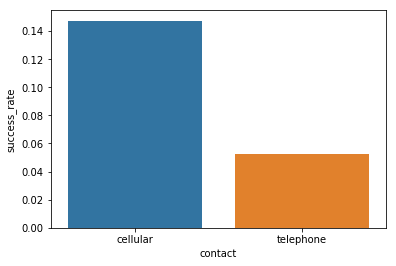

In [33]:
sns.barplot(x=success_by_contact.contact, y=success_by_contact.success_rate);

* Much higher success rate in 'cellular' (assume this is mobile) but this may not be causal - there could be other things that correlate with contact e.g. time of call etc.

***

#### month

In [34]:
success_by_month = df.groupby('month').y.mean().rename('success_rate').reset_index()

In [35]:
def month_index(x):
    if x == 'jan':
        return 1
    elif x == 'feb':
        return 2
    elif x == 'mar':
        return 3
    elif x == 'apr':
        return 4
    elif x == 'may':
        return 5
    elif x == 'jun':
        return 6
    elif x == 'jul':
        return 7
    elif x == 'aug':
        return 8
    elif x == 'sep':
        return 9
    elif x == 'oct':
        return 10
    elif x == 'nov':
        return 11
    elif x == 'dec':
        return 12

In [36]:
success_by_month['month_idx'] = success_by_month.month.apply(month_index)
success_by_month.sort_values(by='month_idx', inplace=True)

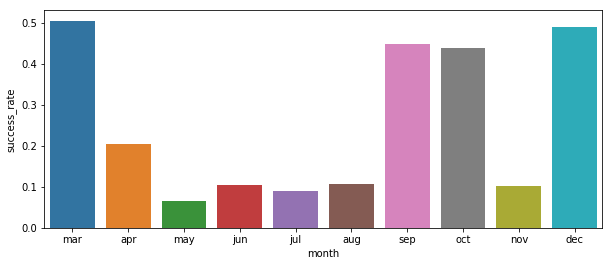

In [37]:
plt.figure(figsize=(10, 4))
sns.barplot(success_by_month.month, success_by_month.success_rate);

* Note sure how to interpret this.  Would need some domain knowlege.  Will leave it out for now.

***

#### day_of_week

In [38]:
success_by_day = df.groupby('day_of_week').y.mean().rename('success_rate').reset_index()

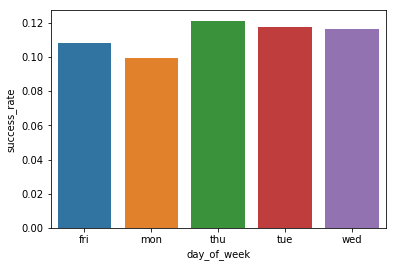

In [39]:
sns.barplot(success_by_day.day_of_week, success_by_day.success_rate);

*  Not much difference in the day of week BUT these ar only week days - the job type showed that people in work had a lower uptake - perhaps becuase they are not in when contacted.
***

#### duration

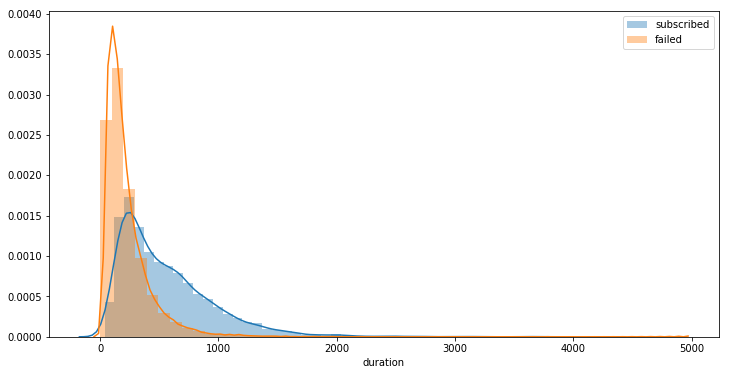

In [42]:
plt.figure(figsize=(12, 6))
sns.distplot(df[successful].duration, label='subscribed')
sns.distplot(df[failed].duration, label='failed')
plt.legend();

* Subsribed had a longer duration but no suprise - they were probably giving info / actually subscribing.  Doubt this is causal.
***

#### campaign

In [1]:
df[successful].campaign.max(), df[failed].campaign.max()

NameError: name 'df' is not defined

* No-one who was contacted more than 23 times subscribed.  Stop contacting them after 23 times.

Worth checking here - are people in work contacted more (because they weren't answering becuase they were at work?).

In [44]:
in_work_jobs = ['blue-collar', 'entrepreneur', 'management', 'services', 
                'admin.', 'technician', 'self-employed', 'housemaid']
out_of_work = ['unemployed', 'student', 'retired']

def employed(x):
    if x in in_work_jobs:
        return True
    elif x in out_of_work:
        return False
    else:
        return np.nan

df['employed'] = df.job.apply(employed)

in_work_contact = df[df.employed == True].campaign.mean()
out_of_work_contact = df[df.employed == False].campaign.mean()
print('NUMBER OF TIMES CONTACTED\n\nIn work:  {:.2f}\nOut of work:  {:.2f}'.format(in_work_contact, out_of_work_contact))

NUMBER OF TIMES CONTACTED

In work:  2.58
Out of work:  2.41


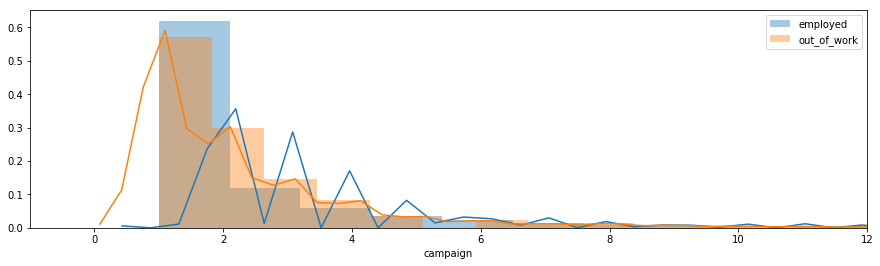

In [45]:
plt.figure(figsize=(15, 4))
sns.distplot(df[df.employed == True].campaign, label='employed')
sns.distplot(df[df.employed == False].campaign, label='out_of_work')
plt.xlim(-1, 12)
plt.legend();

* Not much in this (not what I predicted), perhaps the product itself it more suited to out of work people nd it's not to do with the time / day of contact.
***

#### pdays

A value of 999 means tht they weren't contacted before this campain so worth extracting that data:

In [46]:
df['contacted_before'] = df.pdays.apply(lambda x: False if x == 999 else True)

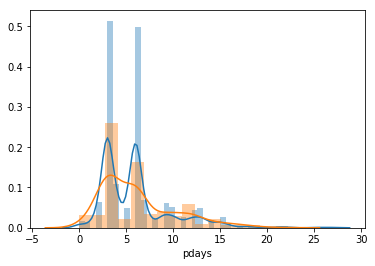

In [47]:
sns.distplot(df[successful].pdays.apply(lambda x: np.nan if x == 999 else x).dropna())
sns.distplot(df[failed].pdays.apply(lambda x: np.nan if x == 999 else x).dropna());

* Not much in there but need to look at 'contacted_before':

In [48]:
success_by_contacted_before = df.groupby('contacted_before').y.mean().rename('success_rate').reset_index()

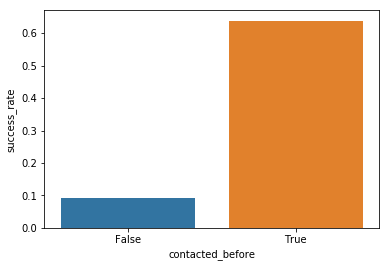

In [49]:
sns.barplot(success_by_contacted_before.contacted_before, success_by_contacted_before.success_rate);

In [50]:
df.contacted_before.value_counts()

False    39673
True      1515
Name: contacted_before, dtype: int64

* Alot higher success rate if contacted before *BUT* there is a much smaller number.  Perhaps there is something else at play here.
***

#### previous

Number of times customer has been contacted before this campaign.

In [51]:
df.previous.value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

In [52]:
success_by_previous = df.groupby('previous').y.mean().rename('success_rate').reset_index()

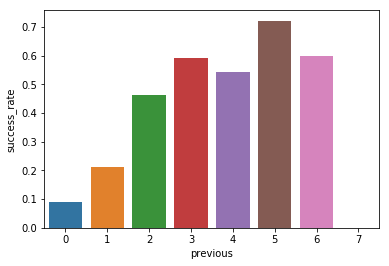

In [53]:
sns.barplot(success_by_previous.previous, success_by_previous.success_rate);

* Are people being contacted more because the bank knows they are more likley to subscribe to products?  Not sure what is causal here. Would be worth talking to someone with domain knowlaedge.  But would be good to see what the count of contacts is.

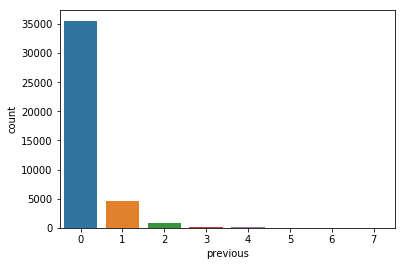

In [48]:
sns.countplot(df.previous);

* *If* the bank are not contacting people deliberately who took up products in the past then there is something in this - possibly people are less willing to take up products in initial contacts? Need to investigate the next feature; poutcome.

#### poutcome

In [49]:
df.poutcome.value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [46]:
success_by_poutcome = df.groupby('poutcome').y.mean().rename('success_rate').reset_index()

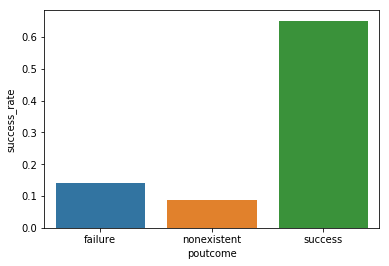

In [166]:
sns.barplot(success_by_poutcome.poutcome, success_by_poutcome.success_rate);

* Much more likley to subscribe if the have in the past.  No big suprise but good to see the confirmation in the data.

Need to look if the bank contacts people more who take it up:

#### emp.var.rate

Not quite sure what this one is (need to ask someone with domain knowledge).

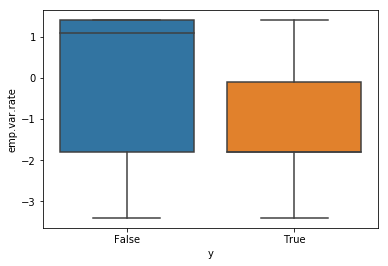

In [175]:
sns.boxplot(y='emp.var.rate', data=df, x='y')

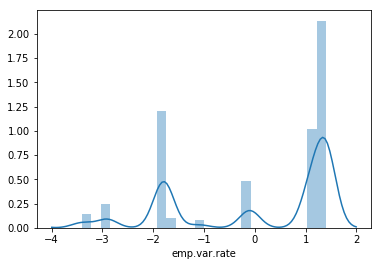

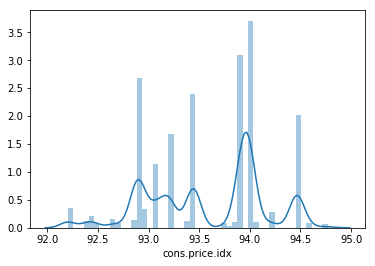

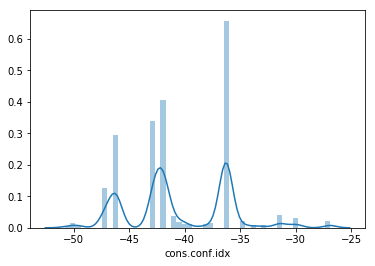

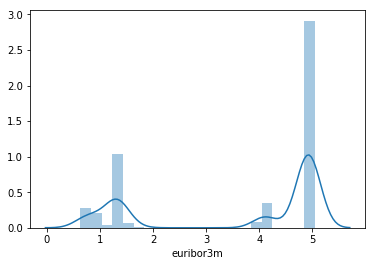

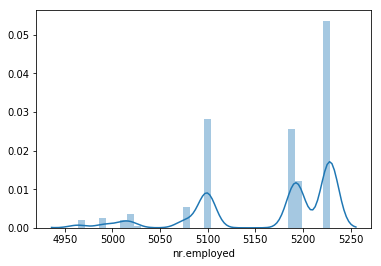

In [61]:
for feature in df_social_data.columns:
    sns.distplot(df[feature])
    plt.show()

Not sure what these are.  Will leave them for now and come back to them with a bit of reasearch if I have time after the other homeworks.
***

## Full Pre-processing

This section contains full pre-processing of the dataframe (ready for modelling), findings of EDA and suggestions for going fowards.  This section may repeat processing from earlier sections as it is written so that it can be run independently.

### Creating of modeling dataframe.

In [3]:
import pandas as pd
import numpy as np

# Load seperate dataframes and combine.
df_bank_client_data = pd.read_csv('data/bank_client_data.csv', sep=':', index_col='ID')
df_last_contacted_data = pd.read_csv('data/last_contact_data.csv', sep='=', index_col='ID')
df_other_data = pd.read_csv('data/other_data.csv', sep=' ', index_col='ID')
df_outcome_data = pd.read_csv('data/outcome_data.csv', sep=' ', index_col='ID')

df = pd.concat(
    [df_bank_client_data, df_last_contacted_data, df_other_data, df_outcome_data], 
    axis=1,
    sort=True
)

# Encoding.
def parse_binary(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return np.nan

for col in ['default', 'housing', 'loan']:
    df[col] = df[col].apply(parse_binary)
df.y = df.y.apply(lambda x: True if x == 'yes' else False)

### Full descriptive graphs and major findings

1. Students and retirees are the most likley to subscribe.

In [70]:
success_by_employed

,employed,success_rate
0,False,0.236354
1,True,0.100674


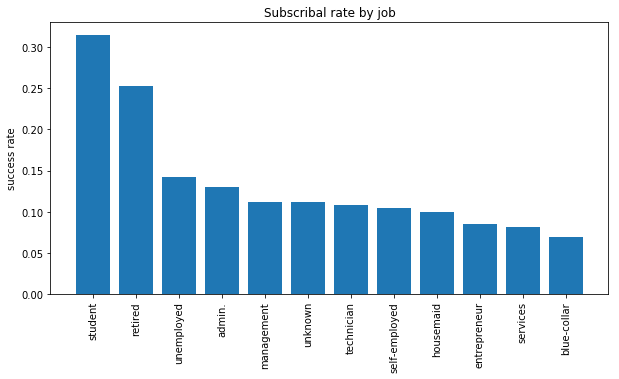

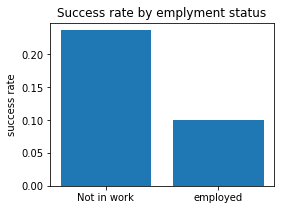

In [74]:
success_by_job.sort_values(by='success_rate', ascending=False, inplace=True)
success_by_employed = df.groupby('employed').y.mean().rename('success_rate').reset_index()

plt.figure(figsize=(10, 5))
plt.bar(success_by_job.job, success_by_job.success_rate)
plt.title('Subscribal rate by job')
plt.ylabel('success rate')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(4, 3))
plt.bar(success_by_employed.employed, success_by_employed.success_rate)
plt.title('Success rate by emplyment status')
plt.xticks(ticks=[0, 1], labels=['Not in work', 'employed'])
plt.ylabel('success rate')
plt.show()

***
2. People who have been in default won't subscribe.

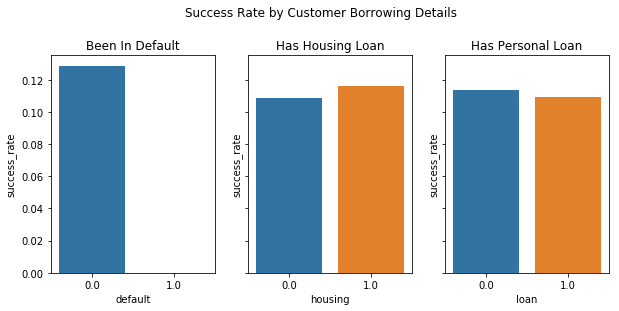

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
sns.barplot(x=success_by_default.default, y=success_by_default.success_rate, ax=ax[0])
sns.barplot(x=success_by_housing.housing, y=success_by_housing.success_rate, ax=ax[1])
sns.barplot(x=success_by_loan.loan, y=success_by_loan.success_rate, ax=ax[2])
ax[0].set_title('Been In Default')
ax[1].set_title('Has Housing Loan')
ax[2].set_title('Has Personal Loan')
plt.suptitle('Success Rate by Customer Borrowing Details', y=1.05);

***
3. No point in contacting more that 23 times.

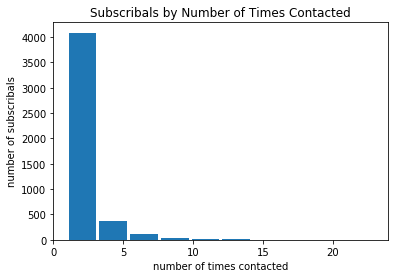

In [111]:
plt.hist(df[successful].campaign, rwidth=0.9)
plt.title('Subscribals by Number of Times Contacted')
plt.xlabel('number of times contacted')
plt.ylabel('number of subscribals');

***
4. The first 2 times they are contacted, they are less likely to subscribe.

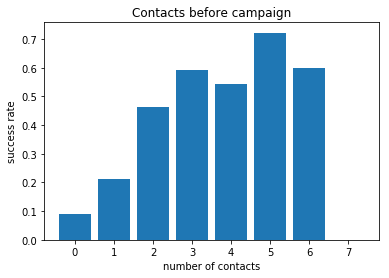

In [112]:
plt.bar(success_by_previous.previous, success_by_previous.success_rate)
plt.title('Contacts before campaign')
plt.xlabel('number of contacts')
plt.ylabel('success rate');

***
5. More likely to subscribe if they have in the past.

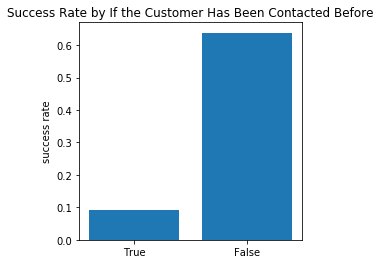

In [120]:
plt.figure(figsize=(4, 4))
plt.bar(success_by_contacted_before.contacted_before, success_by_contacted_before.success_rate)
plt.title('Success Rate by If the Customer Has Been Contacted Before')
plt.xticks([0, 1], ['True', 'False'])
plt.ylabel('success rate');

***

### Questions for someone with domain knowledge

1. Is someone who has been in default able to subscribe?
2. There seems to be a low success rate in the sumer months - any ideas?
***

### Suggestions going fowards:

In [ ]:
# Modeling with prepared dataset.  Logistic regression could be a good start as it will be possible to 
# see the effects of the features, which can then be used by the bank to imporve their campaign.